# GANS + Autoencoders 
## Lívia Cereja Meinhardt

Neste relatório iremos comparar a capacidade de gerar dados (imagens) de três modelos de deep learning: *GANS*, *Autoencoders* e *Variational Autoencoders*. Para isso, serão utilizadas implementações fornecidas nos labs anteriores e tutoriais do Keras. Ademais, a comparação será feita a partir de três configurações diferentes, para cada modelo: utilizando dados de treino, teste e ruído aleatório (estocástico).

Desta forma, será possível compreender como cada um destes modelos se comporta, além de suas principais diferenças. 

### Bibliotecas necessárias:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Input, metrics, optimizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Dados

O conjunto de dados que será utilizado é o Fashion MNIST, que contém imagens de 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

4422102/4422102 [==============================] - 0s 0us/step


## Basic autoencoder

Primeiramente, será treinado um *autoencoder* básico:

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,

                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
def plot_autoencoder(original,output,random=False,dim=64):
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)

    if random: 
      plt.imshow(original[i].reshape(dim,1))
    else:

      plt.imshow(original[i])

    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
  plt.show()


In [ ]:
# basic autoencoder
autoencoder = Autoencoder(latent_dim = 64) 
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,epochs=10,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0238 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

Começamos os testes utilizando o conjunto de validação/teste como input para gerar novas imagens: 

313/313 [==============================] - 0s 1ms/step


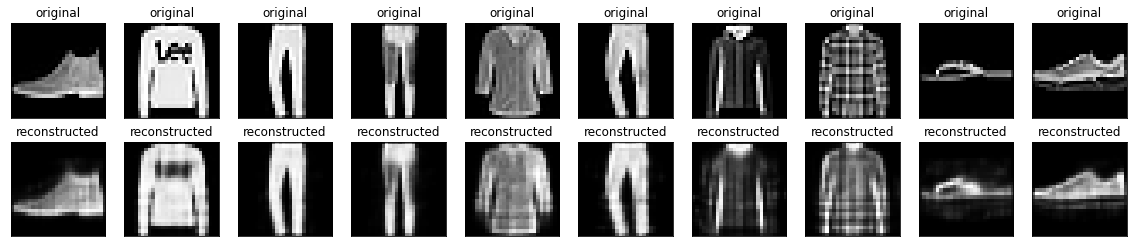

In [ ]:
encoded_imgs = autoencoder.encoder.predict(x_test)
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)
plot_autoencoder(x_test,decoded_imgs)

Agora, utilizando o conjunto de treino:


1875/1875 [==============================] - 2s 1ms/step


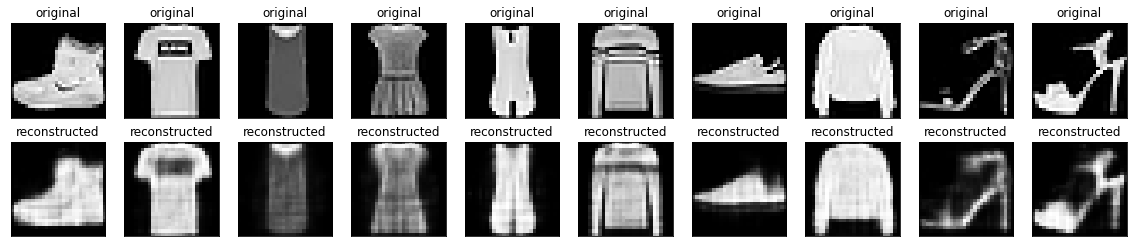

In [ ]:
encoded_imgs = autoencoder.encoder.predict(x_train)
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)
plot_autoencoder(x_train,decoded_imgs)

Por fim, utilizaremos um ruído aleatório. Diferente dos passos anteriores, em que passamos as imagens primeiramente para o encoder, para gerar os vetores do espaço latente, iremos passar o ruído diretamente para o decoder, já que nosso objetivo é gerar novas imagens - e não aprender ou testar representações:

1/1 [==============================] - 0s 15ms/step


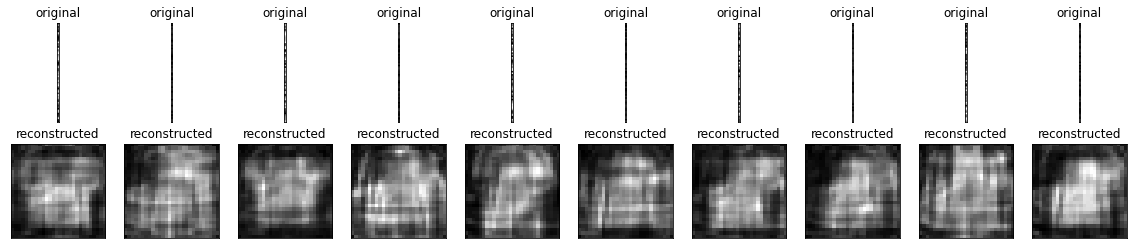

In [ ]:
random_noise = np.random.rand(10,64)
decoded_imgs = autoencoder.decoder.predict(random_noise)
plot_autoencoder(random_noise,decoded_imgs,random=True,dim=64)

### Conclusão

O Autoencoder básico tem como objetivo aprender representações dos dados de entrada (o espaço latente), de forma a partir desta, conseguir recriar a imagem original. Esta técnica é utilizada para redução de dimensionalidade e remoção de ruídos, por exemplo.

Ou seja, somente com esta arquitetura simples, não temos como objetivo gerar novas imagens, como aqui testamos. 

Isto fica evidente na comparação dos resultados utilizando imagens de treino e teste com o ruído aleatório. Quando utilizamos imagens do conjunto de dados original (treino ou teste), o Autoencoder é capaz de representar os dados de uma forma que o decoder consegue reproduzir - com menor qualidade. Esta perda de qualidade surge devido a própria arquitetura e objetivo da rede: aprender as representações da imagem em uma dimensão muito menor (neste caso um vetor com dimensão 64). 

Ou seja, o encoder aprende como representar uma imagem originalmente 28x28 em um vetor 1x64. Assim, é muito difícil que o decoder consiga reproduzir a imagem original perfeitamente, por isso, as imagens geradas nestes testes iniciais são *borradas*.  

Para ilustrar este ponto, a imagem abaixo mostra como fica a imagem gerada pelo decoder utilizando um espaço latente com dimensão 2 ( ou seja um vetor 1x2, extremamente pequeno):

![](https://www.imagemhost.com.br/images/2022/11/19/dim_2_img.png)

As imagens reconstruidas ficam ainda mais borradas - como poderíamos esperar, já que estamos utilizando uma representação de dimensão extremamente baixa (2). 

Dada esta intuição, fica fácil compreender porque os Autoencoders básicos não são capazes de gerar novas imagens a partir de ruído aleatório. O espaço latente não é *organizado* o suficiente para isso: as imagens geradas a partir de dados estocásticos, então, não são identificáveis. 

As imagens geradas com ruído aleatório com espaço latende com 2 dimensões:

![](https://www.imagemhost.com.br/images/2022/11/19/ruido_dim2.png)

Conseguimos até identificar um tênis nas imagens geradas, mas nós já espararíamos isso dado que conheçemos as imagens utilizadas para o treinamento da rede. Mas é interessante ver que o espaço com 64 dimensões parece não ganhar muito na gereação de imagens, para este caso.

Por fim, uma vez treinada a rede com espaço latente com 2 dimensões, podemos gerar uma imagem de como as representações se comportam variando as entradas:

![](https://www.imagemhost.com.br/images/2022/11/19/espaco_latente_2.png)

A rede com apenas duas dimensões não é capaz de aprender todas as representações das imagens de entrada, por isso a qualidade das imagens (para o ruído aleatório, apenas) pode parecer um pouco melhor, mas a rede é menos generalizável, no sentido de que conseguimos gerar somente imagens muito borradas e muito parecidas. Daí, o ganho da dimensção 64.

## Variational AutoEncoder

Agora, seguimos para o *Variational AutoEncoder*:

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean( name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
latent_dim = 2

#Encoder
encoder_inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


#Decoder
latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 32)   320         ['input_9[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_9 (Flatten)            (None, 3136)         0           ['conv2d_9[0][0]']               
                                                                                            

In [ ]:
x_train_vae = np.expand_dims(x_train, -1)
x_test_vae = np.expand_dims(x_test, -1)

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())
vae.fit(x_train_vae, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 5s 9ms/step - loss: 395.3377 - reconstruction_loss: 342.3855 - kl_loss: 5.2111
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 309.5992 - reconstruction_loss: 302.2096 - kl_loss: 6.0105
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 305.3115 - reconstruction_loss: 299.3407 - kl_loss: 5.5088
Epoch 4/30
469/469 [==============================] - 5s 10ms/step - loss: 302.8513 - reconstruction_loss: 297.7906 - kl_loss: 5.2824
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 302.0315 - reconstruction_loss: 296.4313 - kl_loss: 5.1897
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 300.2260 - reconstruction_loss: 295.4585 - kl_loss: 5.1042
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - loss: 299.9210 - reconstruction_loss: 294.4297 - kl_loss: 5.0725
Epoch 8/30
469/469 [==============================] - 5s 11ms/step -

Os dados de teste geram as seguintes imagens:

313/313 [==============================] - 1s 2ms/step


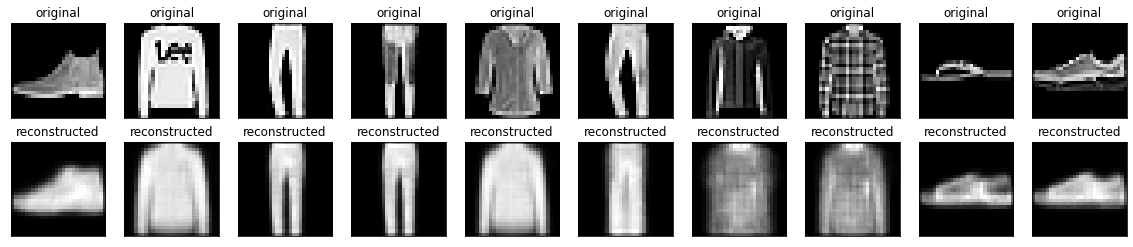

In [ ]:
encoded_imgs = vae.encoder.predict(x_test_vae)
decoded_imgs = vae.decoder.predict(encoded_imgs[0])
plot_autoencoder(x_test_vae.reshape(10000,28,28),decoded_imgs.reshape(10000,28,28))

Nos dados de treino:

1875/1875 [==============================] - 3s 2ms/step


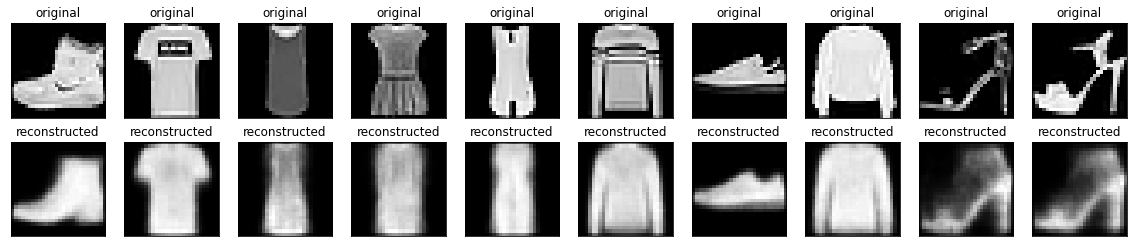

In [ ]:
encoded_imgs = vae.encoder.predict(x_train_vae)
decoded_imgs = vae.decoder.predict(encoded_imgs[0])
plot_autoencoder(x_train_vae.reshape(60000,28,28),decoded_imgs.reshape(60000,28,28))

Finalmente, utilizando ruído aleatório - como anteriormente:

1/1 [==============================] - 0s 15ms/step


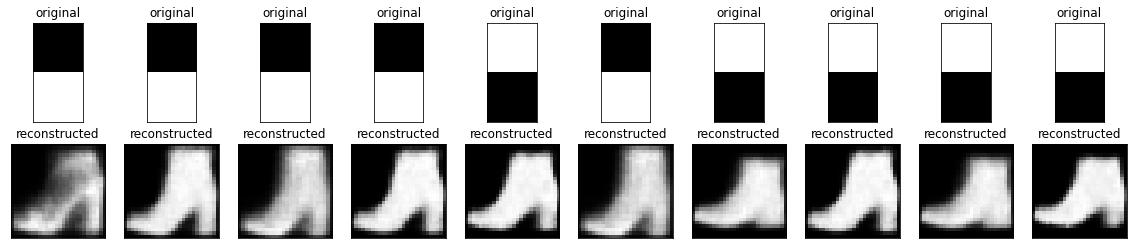

In [ ]:
random_noise = np.random.rand(10,2)
decoded_imgs = vae.decoder.predict(random_noise)
plot_autoencoder(random_noise,decoded_imgs.reshape(10,28,28),random=True,dim=2)

### Conclusão

Diferente do Autoencoder básico, os Autoencoders Variacionais inserem certa *regularização* no espaço latente, de forma que seja possível gerar novas imagens a partir do decodificador. Ao invés de codificar a imagem original como um único ponto (como anteriormente), ela será uma distribuição no espaço latente. O decoder será treinado utilizando uma amostra desta distribuição. A imagem abaixo ilustra esta diferença chave entre os dois métodos:

![](https://www.imagemhost.com.br/images/2022/11/19/explicacao.png)

A VAE então, foi treinada utilizando um espaço latente de dimensão dois, para representar a distribuição a ser amostrada - uma normal padrão. Neste caso então, diferente dos autoencoders básicos aumentar este espaço não tem como consequência uma possível melhora, já que as dimensões representam ideias diferentes: os básicos são um ponto, os variacionais uma distribuição. 

Para ilustrar este arguemnto, se tentarmos treinar a VAE com dimensão 64, como o autoencoder básico, os dados de **treino** retornam uma reconstrução muito borrada:

![](https://www.imagemhost.com.br/images/2022/11/19/dim_64_VAE.png)

Comparando então os resultados do Autoencoder básico (dim 64) e VAE (dim 2) podemos perceber que a qualidade da imagem gerada pelo básico é melhor: mais detalhes são resgatados pela reconstrução da imagem, comparado com este VAE. Isto pode ser causado justamente pelo fato de uma maior dimensão no espaço latente conseguir carregar mais informações para o decodificador. 

Porém, olhando apenas para as imagens geradas a partir do ruído aleatório fica clara a capacidade de generalização da VAE em detrimento do Autoencoder básico. Afinal, a VAE é construída com este objetivo, utilizando o espaço latente como representação de uma *distribuição*, assim, é possível gerar novas imagens alterando os parâmetros passsados para o decodificador. 

Para ilustrar este comentário o espaço latente desta rede (pode ser gerado utilizando a função *plot_latent_space* neste notebook):


![](https://www.imagemhost.com.br/images/2022/11/19/vae_espaco_2.png)

Como podemos ver, a mudana dos parâmetros é muito significativa para a rede e de forma regular: pontos próximos no espaço latente geram imagens com conteúdo similar - como esperado pela continualidade das VAE - e uma amostra decodificada gera conteúdo compreensível - neste caso, temos apenas alguns pontos em que o conteúdo fica *misturado* - observe o ponto (-0.3, 0.3) da imagem acima. 

## GANS

Por fim, veremos a solução das GANS: *Generative Adversarial Networks*:

In [ ]:
!pip install googleDriveFileDownloader
from googleDriveFileDownloader import googleDriveFileDownloader
a = googleDriveFileDownloader()
a.downloadFile("https://drive.google.com/uc?id=1PjYG1ElJTgLhj9tS8MHW93k8qT4wRj6E&export=download")

from zipfile import ZipFile
with ZipFile('dataset.zip', 'r') as myzip:
    myzip.extractall()
dataset_dir = "/content/dataset"

# mount your Google Drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/Face_generation/'
if not os.path.exists(output_dir): os.makedirs(output_dir)

#libs
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, Dropout
from keras.layers.core import Activation
from keras.optimizers import adam_v2
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Download is starting
FILENAME ::: dataset.zip
Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 36.0 MB/s 


Definimos os parâmetros da rede:

In [ ]:
# Parameters
OPTIMIZER = adam_v2.Adam(lr=1e-4)
INPUT_SHAPE = 100
LOSS = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
BATCH_SIZE = 100
EPOCHS = 200

#Distributions: 'normal', 'weibull', 'uniform'
DISTRIBUTION_train = 'uniform'
DISTRIBUTION_test  = 'weibull'
DISTRIBUTION_random = 'normal'

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


A GAN é construida a partir das funções fornecidas, fazendo pequenas adptações devido ao conjunto de dados diferente:

In [ ]:
def create_generator():

    generator = Sequential()
    generator.add(Dense(7 * 7 * 128, input_shape=[100]))
    generator.add(Reshape([7, 7, 128]))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                    activation="relu"))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                    activation="tanh"))


    # model = Sequential()
    # model.add(Dense(7*7*128, input_shape=(INPUT_SHAPE,)))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    # model.add(Reshape((7,7,128)))
  
    # model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))
    # model.add(Dropout(0.1))

    # model.add(Conv2DTranspose(1, (4,4), strides=(2,2),  padding='same'))
    # model.add(Activation('tanh'))

    # model.compile(optimizer=OPTIMIZER, loss=LOSS)
    return generator

def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                            activation=LeakyReLU(0.3),
                            input_shape=[28, 28, 1]))
    discriminator.add(Dropout(0.5))
    discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                            activation=LeakyReLU(0.3)))
    discriminator.add(Dropout(0.5))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))

    # model = Sequential()
    # model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=(28,28,1)))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))

    # model.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))

    # model.add(Conv2D(256, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))

    # model.add(Conv2D(512, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=LEAKY_SLOPE))

    # model.add(Flatten())
    # model.add(Dense(1, activation='sigmoid'))

    # model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

# GAN
def create_GAN(generator, discriminador):
    model = Sequential()
    model.add(generator)
    discriminador.trainable = False
    model.add(discriminador)
    model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

def plot_gans(images):

  fig,axe=plt.subplots(2,5,figsize=(15, 5))
  idx=0
  for i in range(2):
      for j in range(5):
          axe[i,j].imshow(images[idx].reshape(28,28),cmap='gray')
          idx+=3

In [ ]:
generator = create_generator()
discriminador = create_discriminator()
GAN = create_GAN(generator, discriminador)
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2756545   
                                                                 
Total params: 3,597,250
Trainable params: 840,321
Non-trainable params: 2,756,929
_________________________________________________________________


Treinando a GAN usando distribuição normal:

*OBS o algoritmo de treino foi retirado do [Kaggle](https://www.kaggle.com/code/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset)*

In [ ]:
for epoch in range(EPOCHS):

    print(f"EPOCA: {epoch+1}")
    
    for i in range(x_train.shape[0]//BATCH_SIZE):
            
        noise=np.random.normal(size=[BATCH_SIZE,INPUT_SHAPE])
        gen_image = generator.predict_on_batch(noise)
        train_dataset = x_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
       
        #TERINANDO O DISCRIMINADOR COM IMAGENS REAIS
        train_label=np.ones(shape=(BATCH_SIZE,1))
        discriminador.trainable = True
        d_loss_real=discriminador.train_on_batch(train_dataset,train_label)

        #TERINANDO O DISCRIMINADOR COM IMAGENS GERADAS
        train_label=np.zeros(shape=(BATCH_SIZE,1))
        d_loss_fake=discriminador.train_on_batch(gen_image,train_label)
        
        #TREINANDO O GERADOR COM DISTRIBUICAO NORMAL
        noise=np.random.normal(size=[BATCH_SIZE,INPUT_SHAPE])
        train_label=np.ones(shape=(BATCH_SIZE,1))
        discriminador.trainable = False 
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
               
    #Mostrando a evolução do modelo a cada 10 epocas
    if epoch % 10 == 0:
        generator.save(output_dir + 'generator.h5')
        GAN.save(output_dir + 'gan.h5')

        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

print('TREINO COMPLETO')

In [ ]:
import os
from google.colab import drive
from keras.models import load_model

drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/Face_generation/'

generator = load_model(output_dir + '/generator.h5')

Mounted at /content/drive


Começamos usando a distribuição de treino (normal):


4/4 [==============================] - 0s 12ms/step


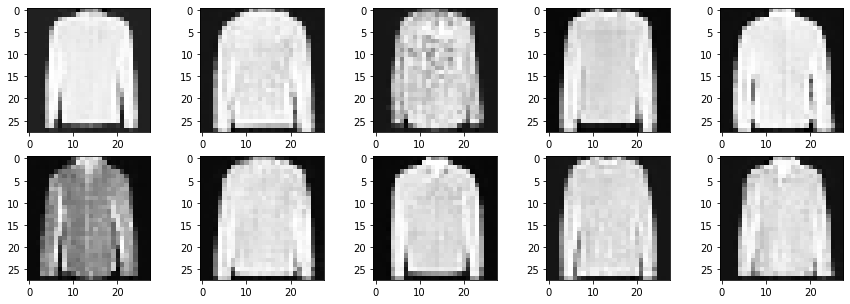

In [ ]:
noise=np.random.normal(loc=0, scale=1, size=(100,INPUT_SHAPE))
gen_image = generator.predict(noise)
plot_gans(gen_image)

Em seguida usamos a distribuição Weibull:

4/4 [==============================] - 0s 3ms/step


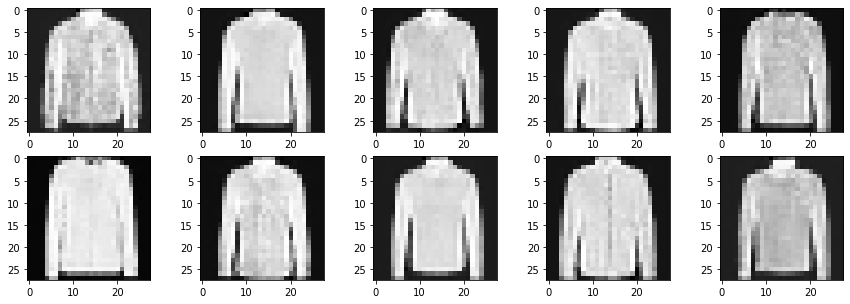

In [ ]:
q = np.random.weibull(50, (100,100))
noise = (q - np.mean(q)) / np.std(q)
gen_image = generator.predict(noise)
plot_gans(gen_image)

Por fim, utilizando a distribuição normal:

4/4 [==============================] - 0s 3ms/step


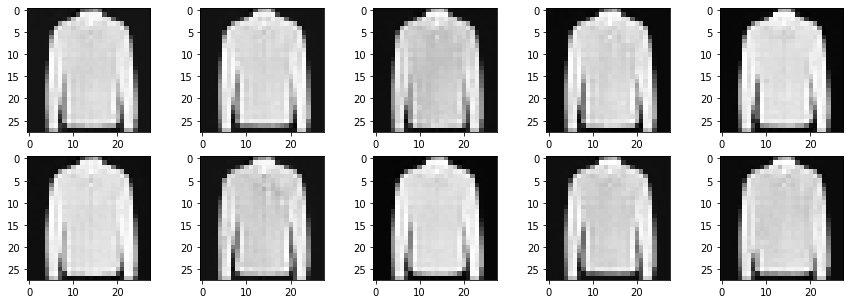

In [ ]:
noise=np.random.rand(100,100)
gen_image = generator.predict(noise)
plot_gans(gen_image)

### Conclusão

Diferente do VAE, em que tenta-se aprender a distribuição dos dados por meio da representação em um espaço com dimensão menor, a GANS gera amostras da distribuição dos dados aprendendo uma transformação de uma distribuição mais simples - neste caso, uma normal - para a desejada. 

Em relação a resolução da imagem, os resultados - para as três distribuções testadas - são bastante satisfatórios e, diferente dos VAE, que também tem ótimo resultado, estas imagens não são borradas: apresentam qualidade similar as das amostras de treino.

Entretanto, neste caso, temos um problema: o modelo treinado não conseguiu generalizar bem. Podemos ver em todos os três testes que essa GAN só foi capaz de gerar camisas, dentre todas as classes disponíveis no conjunto de dados. 

Este resultado não é repetido, por exemplo, nas implementações do [notebook do Kaggle](https://www.kaggle.com/code/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset). A diferença é somente em alguns aspectos da arquitetura utilizada. Porém vemos que apesar de uma melhor generalização, a qualidade das imagens geradas é pior. 

Reproduzindo a arquitetura dessa referência, temos o seguinte resultado para ruído normal:

![](https://www.imagemhost.com.br/images/2022/11/27/imagem_2022-11-27_142148864.png)

Esses resultados não tão satisfatórios vem da própria modelagem e arquitetura da GAN: treiná-las é extremamente mais custoso do que treinar um VAE. Neste caso, mesmo usando 200 épocas e um grande conjunto de dados, não foi suficiente para que a GAN pudesse de fato aprender a transformação da distribuição dos dados corretamente, o que é a explicação para os resultados mostrados. 

Nos testes demostrados a GAN conseguiu aprender bem a distribuição das camisas, porém não foi capaz de gerar nenhuma das outras classes. Ou seja, se especializou em uma única classe. A explicação da *escolha* das camisas entre as outras é um tanto misterioso, já que todas as 10 classes são igualmente distribuidas nos dados de treino. 

Para a segunda arquitetura, a generalização é melhor: criamos imagens com formatos mais distintos. Porém, claramente, a GAN não consegue aprender a amostrar da distribução dos dados perfeitamente.